In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("D:\Projects\Phishing Website Detection\dataset_phishing.csv")
df.head()


,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [3]:
df.shape
df.info()
df['status'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

status
legitimate    5715
phishing      5715
Name: count, dtype: int64

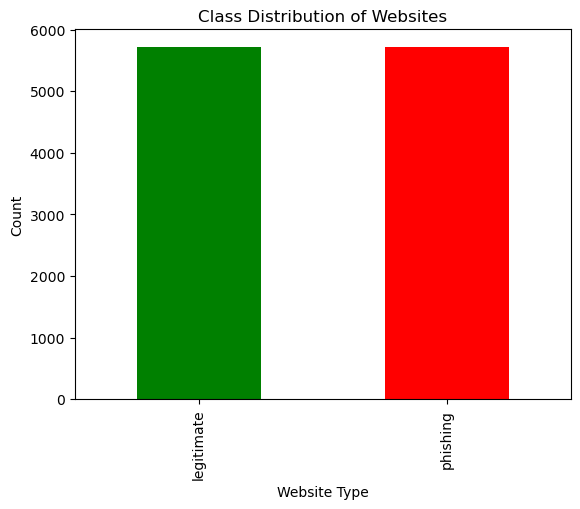

In [4]:
df['status'].value_counts().plot(kind='bar', color=['green','red'])
plt.title("Class Distribution of Websites")
plt.xlabel("Website Type")
plt.ylabel("Count")
plt.show()


This bar chart shows the distribution of legitimate and phishing websites in the original dataset, helping identify class imbalance.

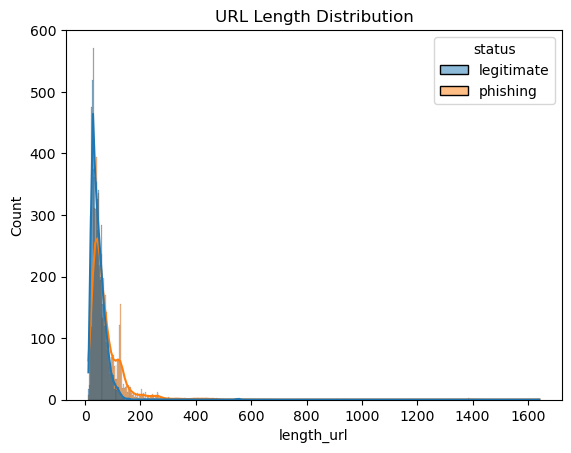

In [5]:
sns.histplot(data=df, x='length_url', hue='status', kde=True)
plt.title("URL Length Distribution")
plt.show()


Phishing URLs generally tend to be longer and more complex than legitimate URLs.

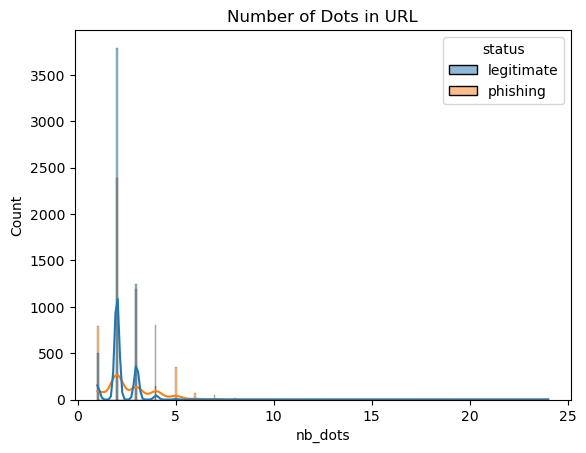

In [6]:
sns.histplot(data=df, x='nb_dots', hue='status', kde=True)
plt.title("Number of Dots in URL")
plt.show()


Phishing URLs often contain multiple dots to mimic subdomains of legitimate websites.

In [7]:
df['status'] = df['status'].map({
    'legitimate': 0,
    'phishing': 1
})


In [8]:
df_refined = df.drop(columns=['url'])


In [9]:
df_refined.isnull().sum().max()
df_refined = df_refined.fillna(0)


In [10]:
df_refined.to_csv("refined_dataset.csv", index=False)


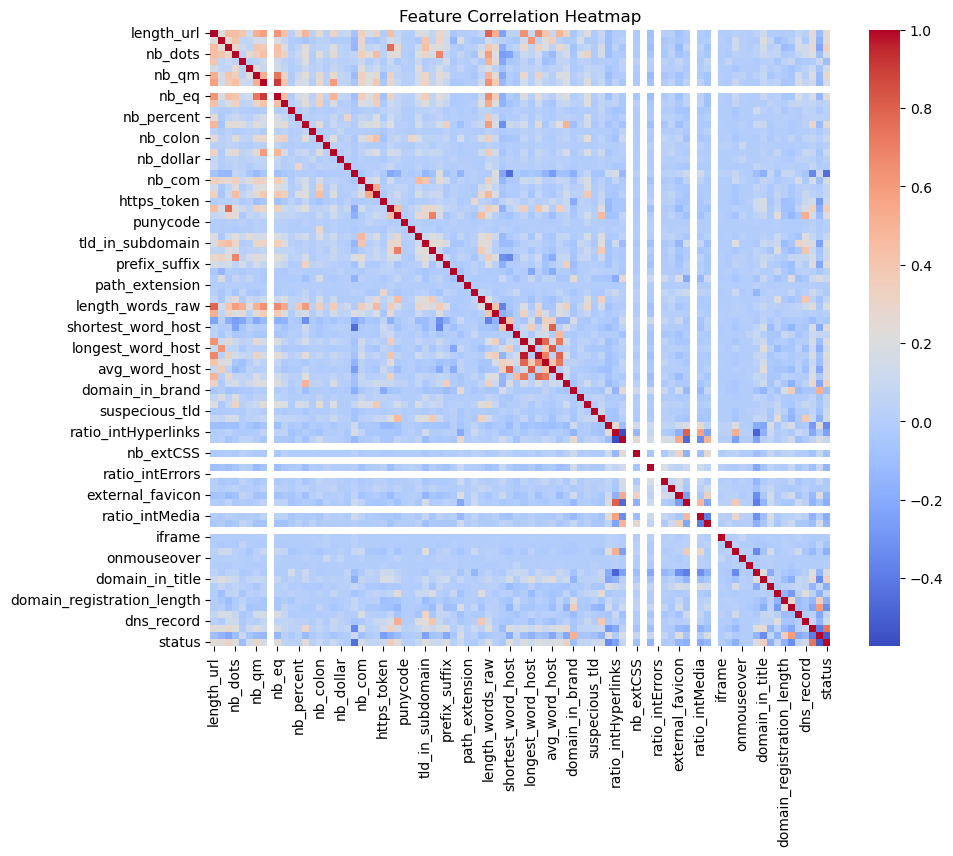

In [11]:
plt.figure(figsize=(10,8))
sns.heatmap(df_refined.corr(), cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


The correlation heatmap shows relationships among features and helps identify redundancy before model training.

In [12]:
df = pd.read_csv("refined_dataset.csv")
X = df.drop(columns=['status'])
y = df['status']


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [14]:
df_preprocessed = pd.DataFrame(X_scaled, columns=X.columns)
df_preprocessed['status'] = y.values

df_preprocessed.to_csv("preprocessed_dataset.csv", index=False)


In [15]:
from sklearn.model_selection import train_test_split

X = df_preprocessed.drop(columns=['status'])
y = df_preprocessed['status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score


In [17]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(eval_metric='logloss', scale_pos_weight=2)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Phishing Recall": recall_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results)
results_df


,Model,Accuracy,Phishing Recall
0,Logistic Regression,0.936570,0.933508
1,Decision Tree,0.933071,0.930009
2,Random Forest,0.964129,0.969379
3,SVM,0.952756,0.950131
4,XGBoost,0.970254,0.976378


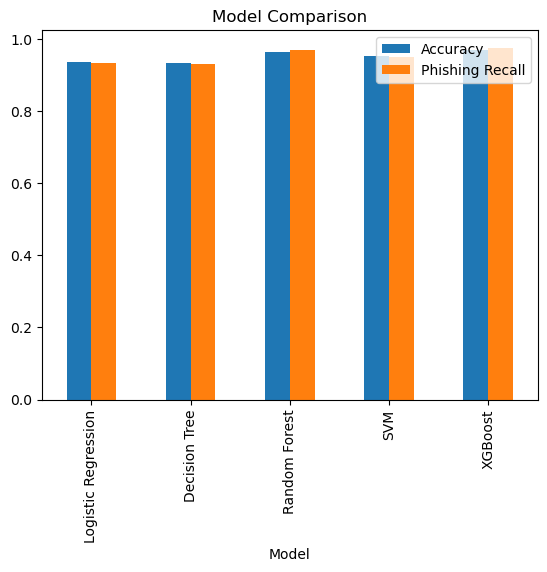

In [18]:
results_df.plot(x='Model', y=['Accuracy','Phishing Recall'], kind='bar')
plt.title("Model Comparison")
plt.show()


Multiple machine learning models were compared using accuracy and phishing recall to select the best-performing model.

In [19]:
best_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=2,
    eval_metric='logloss'
)

best_model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


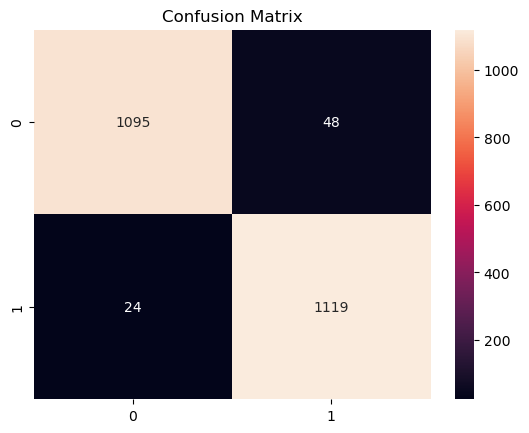

In [20]:
from sklearn.metrics import confusion_matrix

y_pred = best_model.predict(X_test)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()


The confusion matrix highlights correct and incorrect classifications, including false positives and false negatives.

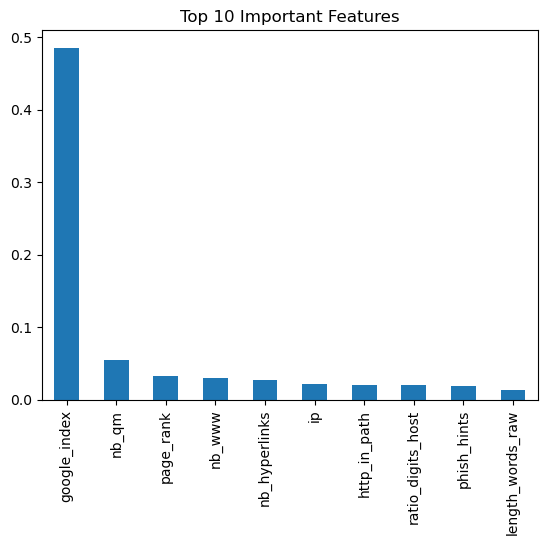

In [21]:
importances = best_model.feature_importances_
pd.Series(importances, index=X.columns).nlargest(10).plot(kind='bar')
plt.title("Top 10 Important Features")
plt.show()


This graph shows the most influential features used by the model for phishing detection.

In [22]:
import joblib

joblib.dump(best_model, "final_phishing_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']